# sentence reconstruction from srt file

In [17]:
import numpy as np
import pandas as pd
import re

In [18]:
path = "C:/Users/NA/Saved Games/eeg_study/modified_500_days_of_summer_subtitle.srt"
#path = "C:/Users/NA/Saved Games/eeg_study/subtitle_all/12_years_a_slave_subtitle.srt"
#path = "C:/Users/NA/Saved Games/eeg_study/subtitle_all/the_usual_suspects_subtitle.srt"
with open(path, "r", encoding='utf-8-sig') as f:
    string = f.read()
    lines = string.split("\n")
    time_arr = []
    subtitles = []
    first_text = True
    continueable = False
    for line in lines:
        if (len(line) < 5 and line.isdigit()) or len(line) == 0:
            continue
            
        if " --> " not in line:
            text = line.strip()
            if continueable : # add subtitle with ... place holder of differnt time annotation
                last_subtitles = subtitles[-1]
                subtitles.pop()
                subtitles.append((last_subtitles + " " + text))

                last_time = time_arr[-2]
                time_arr.pop()
                time_arr.pop()
                time_arr.append((last_time[0], end_time))
                continueable = False
                first_text = False 

            else:
                if "..." in line and not first_text:
                    text = text.replace("...", "")
                    continueable = True
                elif "..." in line and first_text: # add this to skip the continuable if ""..." presence only in the line
                    text = text.replace("...", "")
                    
                if first_text  :
                    subtitles.append(text)
                    first_text = False
                else: # add subtitle between line of the same time annotation
                    last_subtitles = subtitles[-1]
                    subtitles.pop()
                    subtitles.append((last_subtitles + " " + text))

            # to clean data with only time/subtitle
            if len(subtitles) != len(time_arr):
                print(text) 
                print(start_time)
                print(f"len subtitle is {len(subtitles)}")
                print(f"len time ios {len(time_arr)}")

        else:
            first_text = True
            time = line.split(" --> ")
            start = time[0].split(",")[0].split(":")
            end = time[1].split(",")[0].split(":")
            start_ms = time[0].split(",")[1]
            end_ms = time[1].split(",")[1]
            start_time = int(start[0]) * 3600 + int(start[1]) * 60 + float(start[2]) + float(start_ms) / 1000
            end_time = int(end[0]) * 3600 + int(end[1]) * 60 + float(end[2]) + float(end_ms) / 1000
            time_arr.append((start_time, end_time))
    

In [19]:
sentence_arr = pd.DataFrame({
    "start_time": [t[0] for t in time_arr],
    "end_time": [t[1] for t in time_arr],
    "text": subtitles
})

In [20]:
sentence_arr

,start_time,end_time,text
0,61.960,65.16,This is a story of boy meets girl.
1,69.280,77.56,"The boy, Tom Hansen of Margate, New Jersey gre..."
2,77.680,85.08,This belief stemmed from early exposure to sad...
3,85.200,87.40,Elaine! Elaine!
4,87.519,92.60,"The girl, Summer finn of Shinnecock, Michigan ..."
...,...,...,...
1292,5354.960,5358.36,# What's this about I figured love would shine...
1293,5358.479,5361.84,"# We've lost romance This world, its turns wil..."
1294,5361.960,5365.24,# Open your mind Believe it's gonna come true #
1295,5365.359,5368.84,# Keep romance alive and hope she's gonna tell...


In [21]:
def clean_sentence(sentence):
    sentence = re.sub(r'#', '', sentence)  # Remove only hashtag symbol
    #sentence = sentence.lower()               # Lowercase
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove extra spaces
    return sentence.strip()  
sentence_arr['text'] = sentence_arr['text'].apply(clean_sentence)

In [22]:
sentence_arr

,start_time,end_time,text
0,61.960,65.16,This is a story of boy meets girl.
1,69.280,77.56,"The boy, Tom Hansen of Margate, New Jersey gre..."
2,77.680,85.08,This belief stemmed from early exposure to sad...
3,85.200,87.40,Elaine! Elaine!
4,87.519,92.60,"The girl, Summer finn of Shinnecock, Michigan ..."
...,...,...,...
1292,5354.960,5358.36,What's this about I figured love would shine t...
1293,5358.479,5361.84,"We've lost romance This world, its turns will ..."
1294,5361.960,5365.24,Open your mind Believe it's gonna come true
1295,5365.359,5368.84,Keep romance alive and hope she's gonna tell you


# N-gram analysis

# Label text with RoBERTa transformer

## sentiment analysis

### distilbert
2 classes trained with movie review dataset

In [207]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer_disBERT = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model_disBert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

#apply model output probability for each sentiment
all_class_disBERT = []
input_vector = []
for sentence in sentence_arr['text']:
    encoded_input = tokenizer_disBERT(sentence, return_tensors='pt')
    with torch.no_grad():
        logits = model_disBert(**encoded_input).logits
    predicted_class_id = logits.argmax().item()
    all_class_disBERT.append(predicted_class_id)

all_class_disBERT = pd.DataFrame(all_class_disBERT, columns=["dist_bert"])

### emotion data

In [23]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}
    
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

pred_text = sentence_arr['text'].astype('str').tolist()

tokenized_texts = tokenizer(pred_text,truncation=True,padding=True) 
pred_dataset = SimpleDataset(tokenized_texts)
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_text)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_text,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df.insert(0, 'start_time', sentence_arr['start_time'])
df.insert(1, 'end_time', sentence_arr['end_time'])

FILENAME = "./csv_output/500days_of_summer_EMOTIONS.csv"  # name your output file
#df.to_csv(FILENAME)


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### RoBERTA

In [209]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AutoModel
from scipy.special import softmax

#load model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model_sentiment = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [210]:
#apply model output probability for each sentiment
all_scores = []
input_vector = []
for sentence in sentence_arr['text']:
    encoded_input = tokenizer(sentence, return_tensors='pt')
    output = model_sentiment(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    all_scores.append(scores)

In [211]:
# select the most dominat probability and make new column for class
score_roberta = pd.DataFrame(all_scores, columns=['negative', 'neutral', 'positive'])
score_roberta['label'] = score_roberta.apply(lambda x: x.idxmax(), axis=1)
score_roberta['label'] = score_roberta['label'].map({'neutral': 0, 'negative': -1, 'positive': 1})
#score_roberta['label'].to_csv("score_roberta.csv")

In [212]:
score_roberta

,negative,neutral,positive,label
0,0.066079,0.822169,0.111751,0
1,0.155602,0.613484,0.230913,0
2,0.825649,0.166140,0.008211,-1
3,0.020895,0.374968,0.604137,1
4,0.477977,0.510434,0.011589,0
...,...,...,...,...
1292,0.074475,0.533802,0.391723,0
1293,0.431309,0.473081,0.095611,0
1294,0.006481,0.099670,0.893849,1
1295,0.018583,0.301102,0.680314,1


### Vader

In [213]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = []
for sentence in sentence_arr['text']:
    vs = analyzer.polarity_scores(sentence)
    sentiment.append(vs)

In [214]:
score_vader = pd.DataFrame(sentiment)
score_vader['3class_vad'] = score_vader['compound'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))
score_vader['bin1_vad'] = score_vader['compound'].apply(lambda x: 1 if x >= 0 else  0)
score_vader['bin2_vad'] = score_vader['compound'].apply(lambda x: 1 if x > 0 else  0)
#score_vader['label'].to_csv("score_vader.csv")
# 0 neutral, 1 negative, 2 positive

In [215]:
score_vader

,neg,neu,pos,compound,3class_vad,bin1_vad,bin2_vad
0,0.000,1.000,0.000,0.0000,0,1,0
1,0.197,0.803,0.000,-0.6602,-1,0,0
2,0.140,0.860,0.000,-0.4767,-1,0,0
3,0.000,1.000,0.000,0.0000,0,1,0
4,0.146,0.854,0.000,-0.2235,-1,0,0
...,...,...,...,...,...,...,...
1292,0.000,0.656,0.344,0.6369,1,1,1
1293,0.154,0.604,0.242,0.3182,1,1,1
1294,0.000,0.714,0.286,0.4215,1,1,1
1295,0.000,0.397,0.603,0.8442,1,1,1


### textblob

In [216]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
sentiment_tb = []
sentiment_textblob = pd.DataFrame()
for sentence in sentence_arr['text']:
    object_ = TextBlob(sentence)
    sentiment_tb.append(object_.sentiment.polarity)
sentiment_textblob['compond'] = pd.DataFrame(sentiment_tb)

In [217]:
sentiment_textblob['3class_tb'] = sentiment_textblob['compond'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))
sentiment_textblob['bin1_tb'] = sentiment_textblob['compond'].apply(lambda x: 1 if x >= 0 else  0)
sentiment_textblob['bin2_tb'] = sentiment_textblob['compond'].apply(lambda x: 1 if x > 0 else  0)
#score_textblob.to_csv("score_textblob.csv")

In [218]:
sentiment_textblob.iloc[:,1:]

,3class_tb,bin1_tb,bin2_tb
0,0,1,0
1,1,1,1
2,-1,0,0
3,0,1,0
4,0,1,0
...,...,...,...
1292,1,1,1
1293,0,1,0
1294,1,1,1
1295,1,1,1


### export data

In [219]:
score_all = score_vader.iloc[:,4:]
score_all = pd.concat((score_all,sentiment_textblob.iloc[:,1:]),axis =1)
score_all['roberta'] = score_roberta['label']
score_all['distBERT'] = all_class_disBERT
score_all.insert(0, 'sentence', sentence_arr['text'])
score_all.insert(0, 'start_time', sentence_arr['start_time'])
score_all.insert(1, 'end_time', sentence_arr['end_time'])
score_all

,start_time,end_time,sentence,3class_vad,bin1_vad,bin2_vad,3class_tb,bin1_tb,bin2_tb,roberta,distBERT
0,61.960,65.16,This is a story of boy meets girl.,0,1,0,0,1,0,0,1
1,69.280,77.56,"The boy, Tom Hansen of Margate, New Jersey gre...",-1,0,0,1,1,1,0,0
2,77.680,85.08,This belief stemmed from early exposure to sad...,-1,0,0,-1,0,0,-1,0
3,85.200,87.40,Elaine! Elaine!,0,1,0,0,1,0,1,1
4,87.519,92.60,"The girl, Summer finn of Shinnecock, Michigan ...",-1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1292,5354.960,5358.36,What's this about I figured love would shine t...,1,1,1,1,1,1,0,1
1293,5358.479,5361.84,"We've lost romance This world, its turns will ...",1,1,1,0,1,0,0,1
1294,5361.960,5365.24,Open your mind Believe it's gonna come true,1,1,1,1,1,1,1,1
1295,5365.359,5368.84,Keep romance alive and hope she's gonna tell you,1,1,1,1,1,1,1,1


In [220]:
import os
out_name= "500_days_of_summer_new"
out_path = "./image_output/"
csv_path = './csv_output/'
#score_all.to_csv(os.path.join(csv_path,out_name)+ '.csv')

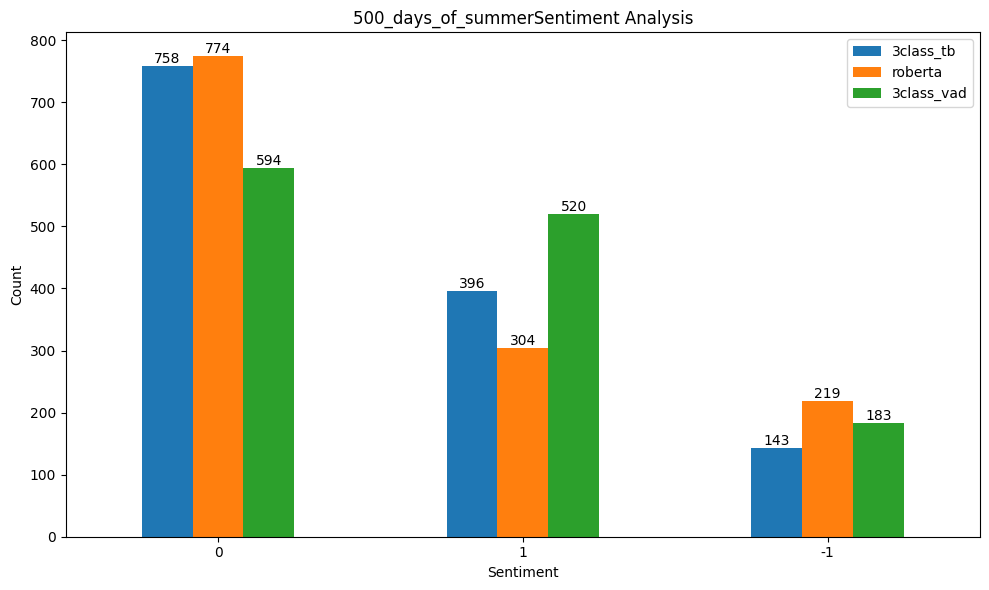

In [221]:
tb = score_all['3class_tb'].value_counts()
roberta = score_all['roberta'].value_counts()
vader = score_all['3class_vad'].value_counts()

# Step 2: Combine into a DataFrame
# This handles missing categories automatically
counts_df = pd.concat([tb, roberta, vader], axis=1, keys=['3class_tb', 'roberta', '3class_vad'])


out_name= "500_days_of_summer"
import matplotlib.pyplot as plt
ax = counts_df.plot(kind='bar', 
                   figsize=(10, 6),
                   rot=0)  # Keep sentiment labels horizontal

# Add labels and title
plt.title( out_name + 'Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.tight_layout()
#plt.savefig(os.path.join(out_path,out_name)+ '.jpg')
plt.show()

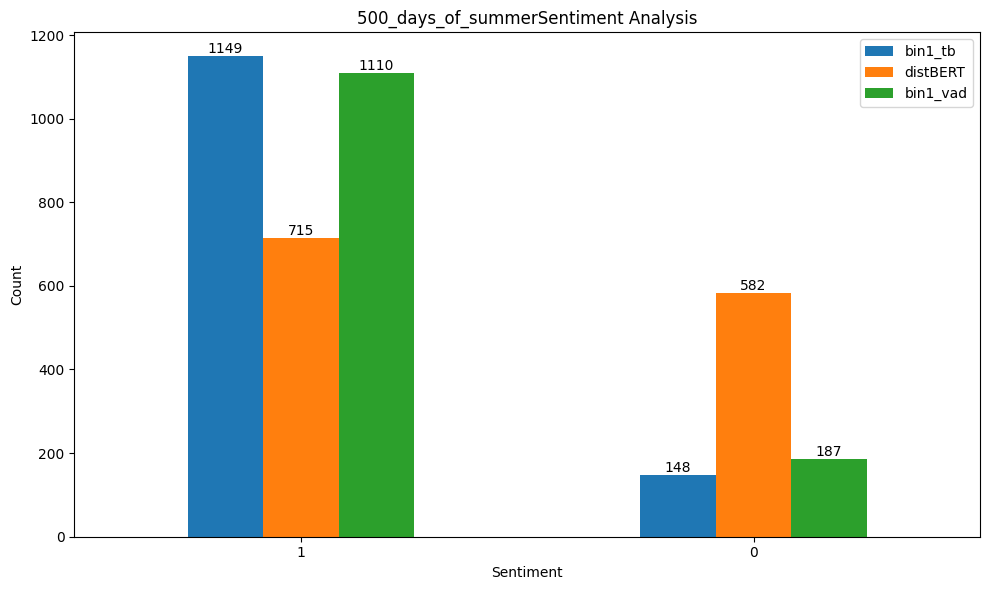

In [222]:
tb_bin1 = score_all['bin1_tb'].value_counts()
roberta_bin1 = score_all['distBERT'].value_counts()
vader_bin1 = score_all['bin1_vad'].value_counts()

# Step 2: Combine into a DataFrame
# This handles missing categories automatically
counts_bin1 = pd.concat([tb_bin1, roberta_bin1, vader_bin1], axis=1, keys=['bin1_tb', 'distBERT', 'bin1_vad'])


out_name= "500_days_of_summer"
import matplotlib.pyplot as plt
ax = counts_bin1.plot(kind='bar', 
                   figsize=(10, 6),
                   rot=0)  # Keep sentiment labels horizontal

# Add labels and title
plt.title( out_name + 'Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.tight_layout()
#plt.savefig(os.path.join(out_path,out_name)+ '.jpg')
plt.show()

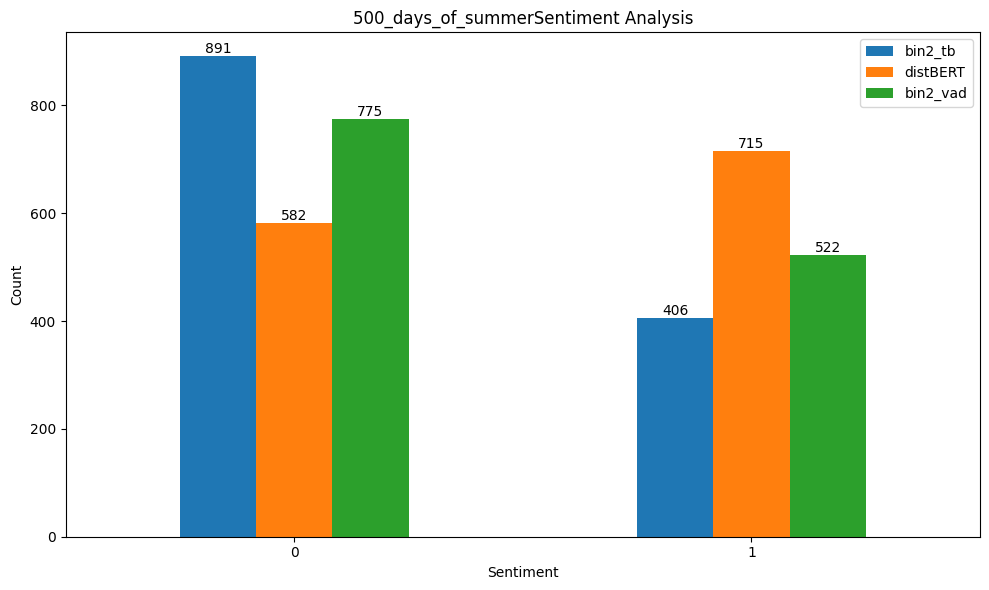

In [229]:
tb_bin2 = score_all['bin2_tb'].value_counts()
roberta_bin2 = score_all['distBERT'].value_counts()
vader_bin2 = score_all['bin2_vad'].value_counts()

# Step 2: Combine into a DataFrame
# This handles missing categories automatically
counts_bin2 = pd.concat([tb_bin2, roberta_bin2, vader_bin2], axis=1, keys=['bin2_tb', 'distBERT', 'bin2_vad'])


out_name= "500_days_of_summer"
import matplotlib.pyplot as plt
ax = counts_bin2.plot(kind='bar', 
                   figsize=(10, 6),
                   rot=0)  # Keep sentiment labels horizontal

# Add labels and title
plt.title( out_name + 'Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.tight_layout()
#plt.savefig(os.path.join(out_path,out_name)+ '.jpg')
plt.show()

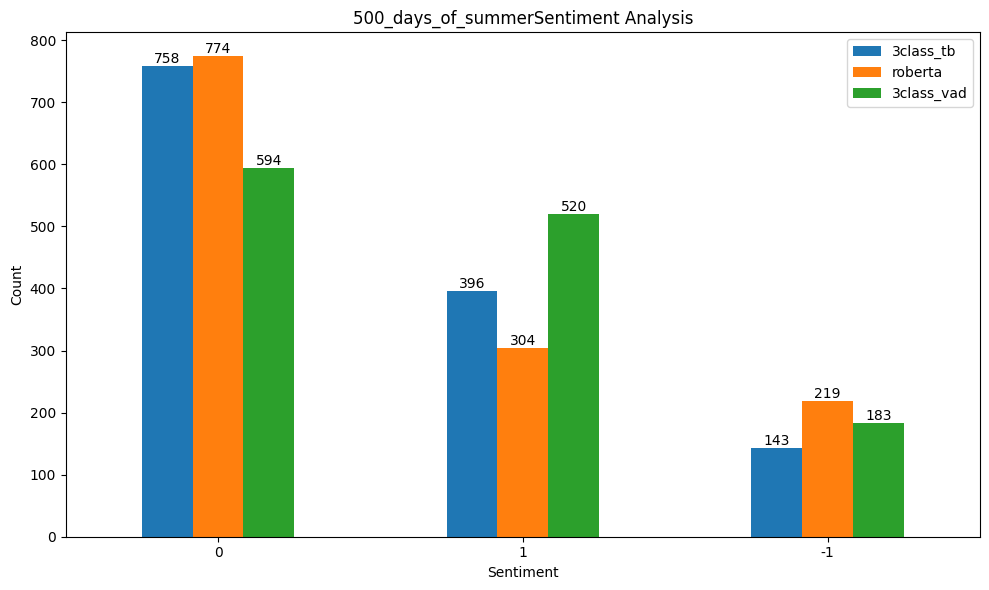

In [224]:
import matplotlib.pyplot as plt
import os

out_name= "500_days_of_summer"
out_path = "./image_output/"
csv_path = './csv_output/'
# Create plot
ax = counts_df.plot(kind='bar', 
                   figsize=(10, 6),
                   rot=0)  # Keep sentiment labels horizontal

# Add labels and title
plt.title( out_name + 'Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.tight_layout()
#plt.savefig(os.path.join(out_path,out_name)+ '.jpg')
plt.show()



### similarity score

In [225]:
sim_3c = sum(x == y for x, y in zip(score_vader['3class_vad'], score_roberta['label'].values )) / len(score_vader['3class_vad'])
sim_bin1 = sum(x == y for x, y in zip(score_vader['bin1_vad'], all_class_disBERT.values )) / len(score_vader['bin1_vad'])
sim_bin2 = sum(x == y for x, y in zip(score_vader['bin2_vad'], all_class_disBERT.values )) / len(score_vader['bin2_vad'])
print(f"similarity score vader roberta multiclass is {sim_3c}")
print(f"similarity score vader roberta bin1 is {sim_bin1}")
print(f"similarity score vader roberta bin2 is {sim_bin2}")

similarity score vader roberta multiclass is 0.6260601387818041
similarity score vader roberta bin1 is [0.65844256]
similarity score vader roberta bin2 is [0.66461064]


In [226]:
sim_3c = sum(x == y for x, y in zip(score_vader['3class_vad'], sentiment_textblob['3class_tb'].values )) / len(score_vader['3class_vad'])
sim_bin1 = sum(x == y for x, y in zip(score_vader['bin1_vad'], sentiment_textblob['bin1_tb'].values )) / len(score_vader['bin1_vad'])
sim_bin2 = sum(x == y for x, y in zip(score_vader['bin2_vad'], sentiment_textblob['bin2_tb'].values )) / len(score_vader['bin2_vad'])
print(f"similarity score vader textblob multiclass is {sim_3c}")
print(f"similarity score vader textblob bin1 is {sim_bin1}")
print(f"similarity score vader textblob bin2 is {sim_bin2}")

similarity score vader textblob multiclass is 0.6322282189668466
similarity score vader textblob bin1 is 0.8619892058596762
similarity score vader textblob bin2 is 0.71781033153431


In [227]:
sim_3c = sum(x == y for x, y in zip(score_roberta['label'].values, sentiment_textblob['3class_tb'].values )) / len(sentiment_textblob['3class_tb'])
sim_bin1 = sum(x == y for x, y in zip( all_class_disBERT.values, sentiment_textblob['bin1_tb'].values )) / len(sentiment_textblob['bin1_tb'])
sim_bin2 = sum(x == y for x, y in zip( all_class_disBERT.values, sentiment_textblob['bin2_tb'].values )) / len(sentiment_textblob['bin2_tb'])
print(f"similarity score roberta textblob multiclass is {sim_3c}")
print(f"similarity score distBERT textblob bin1 is {sim_bin1}")
print(f"similarity score distBERT textblob bin2 is {sim_bin2}")

similarity score roberta textblob multiclass is 0.6684656900539707
similarity score distBERT textblob bin1 is [0.61912105]
similarity score distBERT textblob bin2 is [0.63993832]


## emotion analysis

# Change word to vector 

## sentence / word tokenization and embeddingh

### word2vec embedding

In [50]:
# word2vec
def sentence_to_vec(sentence, model, vector_size=300):
    words = sentence.lower().split()  
    #tokens = [re.sub(r'\W+', '', token) for token in words] 
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# load model to embed the word into vector
from gensim.models import Word2Vec
from gensim.downloader import load
model_w2v = load("word2vec-google-news-300")

In [51]:
# check word in dict
tokens = ['this', 'is', 'a', 'story', 'of', 'boy', 'meets', 'girl']
tokens2 = ['the', 'boy', 'tom', 'hansen', 'of', 'margate', 'new', 'jersey', 'grew', 'up', 'believing', 'that', 'hed',
            'never', 'truly', 'be', 'happy', 'until', 'the', 'day', 'he', 'met', 'the', 'one']
valid_tokens = [token for token in tokens if token in model_w2v]
print("Tokens in model:", valid_tokens)

valid_tokens2 = [token for token in tokens2 if token in model_w2v]
print("Tokens 2 in model:", valid_tokens2)

Tokens in model: ['this', 'is', 'story', 'boy', 'meets', 'girl']
Tokens 2 in model: ['the', 'boy', 'tom', 'hansen', 'new', 'jersey', 'grew', 'up', 'believing', 'that', 'hed', 'never', 'truly', 'be', 'happy', 'until', 'the', 'day', 'he', 'met', 'the', 'one']


### distolbert-tokenization and embedding

In [ ]:
import torch
import tqdm
def get_cls_embeddings_from_series(text_series, tokenizer,model, max_length=128, batch_size=1):
    """
    Converts a Pandas Series of text into a NumPy array of CLS embeddings using DistilBERT.
    where CLS is used in the model as a sentence embedding. 

    Parameters:
        text_series (pd.Series): Series of text strings
        max_length (int): Maximum token length per sentence
        batch_size (int): Batch size for processing (optional, useful for large sets)

    Returns:
        np.ndarray: Array of shape (n_samples, 768) containing CLS embeddings
    """
    cls_embeddings = []

    for text in text_series:
        encoded_input = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=max_length
        )

        with torch.no_grad():
            output = model(**encoded_input)

        cls_vec = output.last_hidden_state[:, 0, :]  # [1, 768]
        #cls_embeddings.append(cls_vec.squeeze(0).numpy())  # [768]
        cls_embeddings.append(np.expand_dims(cls_vec.squeeze(0).numpy(), axis=0))

    return np.vstack(cls_embeddings) # shape: [num_sentences, 768]

### sentiment_tokenization from roberta model

In [53]:
# sentiment_tokenization
model_cardiff = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer_ = AutoTokenizer.from_pretrained(model_cardiff)

def car_diff_embed(text_series, max_length=128, batch_size=1):

    car_diff = []
    for text in text_series:

        embedding_cardiff = tokenizer_(
            text,
            return_tensors='pt',       # Return PyTorch tensors
            padding='max_length',      # Pad all to the same max_length
            truncation=True,           # Truncate if over max_length
            max_length=162      
        )

        car_diff.append(embedding_cardiff['input_ids'].numpy())

    return car_diff 

In [86]:
features

array([[ 0.6997454 ,  0.15458025, -0.01059891, ...,  0.47170144,
         0.93815315, -0.41023418],
       [-0.54252654,  0.6246307 ,  0.03168805, ..., -0.15648341,
        -0.71036536, -0.00857123]], dtype=float32)

### run embedding and tokenization function

In [ ]:
# distilbert fine-tuned with standford dataset for sentiment analysis SST2
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer_BERT = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_BERT = DistilBertModel.from_pretrained("distilbert-base-uncased")
model_BERT.eval()

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer_sentence_finetuned = AutoTokenizer.from_pretrained(model_name)
model_sentence_finetuned = AutoModel.from_pretrained(model_name)  
model_sentence_finetuned.eval()



sentence_arr['embedding_w2v'] = sentence_arr['text'].apply(lambda x: np.array(sentence_to_vec(x, model_w2v)))
embedding_tfm = get_cls_embeddings_from_series(sentence_arr['text'], tokenizer= tokenizer_BERT, model= model_BERT)
embedding_sst = get_cls_embeddings_from_series(sentence_arr['text'], tokenizer= tokenizer_sentence_finetuned, model= model_sentence_finetuned)

embedding_cardiff = np.squeeze(np.array(car_diff_embed(sentence_arr['text'])))

sentence_arr['vader'] = score_vader['label']
sentence_arr['roberta'] = score_roberta['label']
sentence_arr['textB'] = score_textblob

In [77]:
from sentence_transformers import SentenceTransformer
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")
model_mpnet = SentenceTransformer("all-mpnet-base-v2")
embedding_miniLM = model_miniLM.encode(sentence_arr['text'].values)
embedding_mpnet = model_mpnet.encode(sentence_arr['text'].values)

c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NA\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to r

## classification sentiment with word vector as a feature

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

### word2vec

In [64]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7059

=== Training: SVM (linear) ===
Validation Accuracy: 0.7914

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7380


In [65]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.6310

=== Training: SVM (linear) ===
Validation Accuracy: 0.6684

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6578


In [66]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7968

=== Training: SVM (linear) ===
Validation Accuracy: 0.8021

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7647


### distilbert embedding

In [67]:

X = embedding_tfm
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.5294

=== Training: SVM (linear) ===
Validation Accuracy: 0.4920

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.5401


In [68]:
X = embedding_cardiff
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 162) | Val size: (187, 162) | Test size: (187, 162)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.5508

=== Training: SVM (linear) ===
Validation Accuracy: 0.5775

=== Training: XGBoost ===
Validation Accuracy: 0.5455


In [69]:
X = embedding_cardiff
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 162) | Val size: (187, 162) | Test size: (187, 162)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6364

=== Training: SVM (linear) ===
Validation Accuracy: 0.6310

=== Training: XGBoost ===
Validation Accuracy: 0.6524


### sentence embedding

In [ ]:
X = embedding_miniLM
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.6952

=== Training: SVM (linear) ===
Validation Accuracy: 0.6738

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6684


In [ ]:
X = embedding_miniLM
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7273

=== Training: SVM (linear) ===
Validation Accuracy: 0.7166

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7219


In [ ]:
X = embedding_miniLM
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7487

=== Training: SVM (linear) ===
Validation Accuracy: 0.7701

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7380


### Sentence transformer mpnet

In [78]:
X = embedding_mpnet
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7112

=== Training: SVM (linear) ===
Validation Accuracy: 0.7059

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6898


In [79]:
X = embedding_mpnet
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7166

=== Training: SVM (linear) ===
Validation Accuracy: 0.7005

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6471


In [ ]:
X = embedding_mpnet
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7380

=== Training: SVM (linear) ===
Validation Accuracy: 0.7594

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7112


### Sentence transformer fine-tunedsst
currently perform the best for all

In [90]:
X = embedding_sst
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7594

=== Training: SVM (linear) ===
Validation Accuracy: 0.7273

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7594


In [91]:
X = embedding_sst
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7166

=== Training: SVM (linear) ===
Validation Accuracy: 0.7112

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7273


In [92]:
X = embedding_sst
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7594

=== Training: SVM (linear) ===
Validation Accuracy: 0.7059

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7487


### use the sentiment score

In [386]:
X = score_roberta.iloc[:,:-1]
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 3) | Val size: (187, 3) | Test size: (187, 3)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.9893

=== Training: SVM (linear) ===
Validation Accuracy: 0.9786

=== Training: XGBoost ===
Validation Accuracy: 0.9786


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [405]:
np.expand_dims(score_vader.iloc[:,3],axis = 1).shape

(1245, 1)

In [406]:
X = np.expand_dims(score_vader.iloc[:,3],axis = 1)
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 1) | Val size: (187, 1) | Test size: (187, 1)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.9572

=== Training: SVM (linear) ===
Validation Accuracy: 0.9947

=== Training: XGBoost ===
Validation Accuracy: 1.0000


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:22:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
